In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, Tuple
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa    

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError

import pandas as pd
import skbio
from skbio import TreeNode
from io import StringIO
from ete3 import Tree
from skbio import diversity 
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis
import warnings
from collections import Counter
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal
import pytorch_lightning as pl
from io import StringIO
from ete3 import Tree
import phylodm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray import train, tune
from ray.tune import ResultGrid
from scipy.spatial import procrustes
from geomloss import SamplesLoss

from downstream_model import MultiTaskModel

#https://pyimagesearch.com/2023/10/02/a-deep-dive-into-variational-autoencoders-with-pytorch/
#https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
#https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

/Users/zkarwowska/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%cd ..

/Users/zkarwowska/TomaszLab Dropbox/Zuzanna Karwowsk/My Mac (zkarwowska’s MacBook Pro)/Desktop/microbiome_gpt


In [5]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [6]:
pathways1 = pd.read_csv('inputs/AsnicarF_2021_pathways.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways2 = pd.read_csv('inputs/VilaAV_2018_pathways.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways = pd.concat([pathways1, pathways2], axis=0)

taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
taxonomy = taxonomy[taxonomy.index.isin(pathways.index)]

metadata = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()
metadata = metadata[metadata['sample_id'].isin(taxonomy.index)]

metadata['SICK'] = np.where(metadata.disease == 'healthy', 0, 1)

In [7]:
drop_cols = pathways.filter(like = 'UNINTEGRATED').columns.tolist() + pathways.filter(like = 'UNMAPPED').columns.tolist() + pathways.filter(like = '|unclassified').columns.tolist()
pathways = pathways.drop(columns=drop_cols)
pathways_strat = pathways.filter(like = '|')
pathways_unstrat = pathways.drop(columns = pathways_strat.columns)

## Prepare input data

In [8]:
## Filter low abundance bacteria
def filter_prevalence(df, treshold = 0.1):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-3):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_taxonomy = filter_on_abundance(filter_prevalence(taxonomy))
filtered_pathways = filter_on_abundance(filter_prevalence(pathways_unstrat))

In [9]:
## Change to relative abundance
taxonomy_relab_df = filtered_taxonomy.div(filtered_taxonomy.sum(axis=1), axis=0)
pathways_relab_df = filtered_pathways.div(filtered_pathways.sum(axis=1), axis=0)

In [10]:
## Filter out train and validation set
train_taxonomy = taxonomy_relab_df.sample(1000, random_state = 42)
train_pathways = pathways_relab_df[pathways_relab_df.index.isin(train_taxonomy.index)]

train_taxonomy.shape, train_pathways.shape

((1000, 100), (1000, 197))

## Split to train and test

In [11]:
X_taxonomy_train, X_taxonomy_test = train_test_split(train_taxonomy, test_size=0.3, random_state=42)
X_pathways_train, X_pathways_test = train_test_split(train_pathways, test_size=0.3, random_state=42)

In [12]:
PA_matrix = pd.read_csv('inputs/PA_matrix.csv', index_col = [0])

## Prepare phylogenetic data

In [13]:
## Prepare phylogenetic distance matrix
dm = pd.read_csv('inputs/phyloM.csv', index_col = [0])

dm = dm[train_taxonomy.columns]
dm = dm[dm.index.isin(train_taxonomy.columns)]
dm = dm.sort_index().T.sort_index()

dm = dm.reindex(X_taxonomy_train.columns).T.reindex(X_taxonomy_train.columns)

In [14]:
def phylogeny_transform_data(x, U, S):
    result = (x @ U) / np.sqrt(S)
    return result

def inv_phylogeny_transform_data(x, U, S):
    x_recovered = (x * np.sqrt(S)) @ np.linalg.inv(U)
    return x_recovered

T=1

U, S, Vh = np.linalg.svd(np.exp(-dm.values/T), hermitian=True) #The eigenvectors corresponding to distinct eigenvalues of a Hermitian matrix are orthogonal to each other.

X_taxonomy_train_transformed = pd.DataFrame(np.apply_along_axis(phylogeny_transform_data, 1, X_taxonomy_train.values, U=U, S=S), columns = X_taxonomy_train.columns, index = X_taxonomy_train.index)
X_taxonomy_test_transformed = pd.DataFrame(np.apply_along_axis(phylogeny_transform_data, 1, X_taxonomy_test.values, U=U, S=S), columns = X_taxonomy_test.columns, index = X_taxonomy_test.index)

X_train_taxonomy_tensor = torch.tensor(X_taxonomy_train_transformed.values, dtype=torch.float32)
X_train_pathways_tensor = torch.tensor(X_pathways_train.values, dtype=torch.float32)

X_test_taxonomy_tensor = torch.tensor(X_taxonomy_test_transformed.values, dtype=torch.float32)
X_test_pathways_tensor = torch.tensor(X_pathways_test.values, dtype=torch.float32)

# PREPARE VALIDATION DATA

In [15]:
TAXONOMY = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
PATHWAYS = pd.read_csv('inputs/pathways.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
METADATA = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()

METADATA['SICK'] = np.where(METADATA.disease == 'healthy', 0, 1)

pathways_val1 = pd.read_csv('inputs/HMP_2019_ibdmdb_pathways.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways_val2 = pd.read_csv('inputs/HMP_2019_ibdmdb_pathways_healthy.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways_val = pd.concat([pathways_val1, pathways_val2], axis=0)

metadata_val = METADATA[METADATA['sample_id'].isin(pathways_val.index)]
val_samples = metadata_val.drop_duplicates(subset = 'subject_id').sample_id
metadata_val = metadata_val[metadata_val.sample_id.isin(val_samples)].set_index('sample_id')[['age', 'BMI', 'SICK']].dropna()

val_samples = metadata_val.index

taxonomy_val = TAXONOMY[TAXONOMY.index.isin(val_samples)].sort_index()
pathways_val = PATHWAYS[PATHWAYS.index.isin(val_samples)].sort_index()
metadata_val = metadata_val.sort_index()


# FIlter only features that are in the model
pathways_val = pathways_val[X_pathways_train.columns]
taxonomy_val = taxonomy_val[X_taxonomy_train.columns]

# Change to relative abundance
pathways_val = pathways_val.div(pathways_val.sum(axis=1), axis=0)
taxonomy_val = taxonomy_val.div(taxonomy_val.sum(axis=1), axis=0)

# Transform wity phylogeny
X_taxonomy_val_transformed = pd.DataFrame(np.apply_along_axis(phylogeny_transform_data, 1, taxonomy_val.values, U=U, S=S), columns = taxonomy_val.columns, index = taxonomy_val.index)

# Transform into a tensor
X_val_taxonomy_tensor = torch.tensor(X_taxonomy_val_transformed.values, dtype=torch.float32)
X_val_pathways_tensor = torch.tensor(pathways_val.values, dtype=torch.float32)

#### You can only multiply matrices if the number of columns of the first matrix is the same as the number of rows as the second matrix. For example, say you want to multiply A x B. If A is a 3x1 matrix, B has to be a 1xY matrix (Y can be any number), because A only has 1 column.

## DEFINE MODEL

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class GeneToPathwayLayer(nn.Module):
    def __init__(self, num_genes, num_pathways, presence_absence_matrix):
        super(GeneToPathwayLayer, self).__init__()
        self.num_genes = num_genes
        self.num_pathways = num_pathways
        
        # Initialize weights to connect genes to pathways
        self.weights = nn.Parameter(torch.randn(num_genes, num_pathways))
        
        # Presence/Absence matrix (should be of shape (num_genes, num_pathways))
        self.presence_absence_matrix = presence_absence_matrix
        
    def forward(self, x, pathway_abundance=None):
        masked_weights = self.weights * self.presence_absence_matrix
        
        pathway_output = torch.matmul(x, masked_weights)  # (N, num_genes) -> (N, num_pathways)
        
        if pathway_abundance is not None:

            pathway_output = pathway_output * pathway_abundance  # Element-wise multiplication (N, num_pathways)
        
        return pathway_output

class VariationalAutoencoder(nn.Module):
    def __init__(self, num_genes, num_pathways, latent_dim, presence_absence_matrix):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_genes = num_genes
        self.num_pathways = num_pathways
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.input_layer = nn.Linear(num_genes, num_genes)  # (100, 100)
        self.gene_to_pathway = GeneToPathwayLayer(num_genes, num_pathways, presence_absence_matrix)  # (100, 10)
        
        # Latent space (mean and log-variance)
        self.fc_mu = nn.Linear(num_pathways, latent_dim)  # (10, 20)
        self.fc_logvar = nn.Linear(num_pathways, latent_dim)  # (10, 20)
        
        # Decoder layers
        self.decode_latent = nn.Linear(latent_dim, num_pathways)  # (20, 10)
        self.decode_pathway = nn.Linear(num_pathways, num_genes)  # (10, 100)
        
    def encode(self, x, pathway_abundance=None):
        x = torch.relu(self.input_layer(x))  # (N, 100) -> (N, 100)
        x = torch.relu(self.gene_to_pathway(x, pathway_abundance))  # (N, 100) -> (N, 10)
        mu = self.fc_mu(x)  # (N, 10) -> (N, 20)
        logvar = self.fc_logvar(x)  # (N, 10) -> (N, 20)
        return mu, logvar
    
    def reparameterize(self, mean, log_var):
        batch, dim = mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(mean.device)
        return mean + torch.exp(0.5 * log_var) * epsilon
    
    def decode(self, z):
        z = torch.relu(self.decode_latent(z))  # (N, 20) -> (N, 10)
        z = self.decode_pathway(z)  # (N, 10) -> (N, 100)
        return z
    
    def forward(self, x, pathway_abundance=None):
        mu, logvar = self.encode(x, pathway_abundance)  # (N, 100) -> (N, 20), (N, 20)
        z = self.reparameterize(mu, logvar)  # (N, 20)
        recon_x = self.decode(z)  # (N, 20) -> (N, 100)
        return recon_x, mu, logvar, z
    
    
def loss_function(x, x_hat, mean, logvar, phylo_weight = 1, beta = 1e-3):
    
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    return reproduction_loss + beta*KLD

def calculate_disparity(x_pred, x_true):
    try:
        
        x_pred_inv = np.apply_along_axis(inv_phylogeny_transform_data, 1, x_pred.detach().numpy(), U=U, S=S)
        x_true_inv = np.apply_along_axis(inv_phylogeny_transform_data, 1, x_true.detach().numpy(), U=U, S=S)

        pcoa1 = pcoa(squareform(pdist(x_pred_inv))).samples; pcoa2 = pcoa(squareform(pdist(x_true_inv))).samples
        
        Tmtx1, Tmtx2, Tdisp = procrustes(pcoa1.iloc[:, :2], pcoa2.iloc[:, :2])
    
    except:
        Tdisp=1
    
    return Tdisp

In [29]:
class DownstreamModel(nn.Module):
    def __init__(self, input_dim, hidden_units=32, activation=nn.ReLU):
        super(DownstreamModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)

        # Output layers for each task
        self.fc_age = nn.Linear(hidden_units, 1)  # For predicting age (continuous)
        self.fc_bmi = nn.Linear(hidden_units, 1)  # For predicting BMI (continuous)
        self.fc_health = nn.Linear(hidden_units, 1)  # For predicting health (binary)

        self.activation = activation()
        self.sigmoid = nn.Sigmoid()  # For binary output

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        age_out = self.fc_age(x)
        bmi_out = self.fc_bmi(x)
        health_out = self.sigmoid(self.fc_health(x))  # Apply sigmoid to binary output

        return age_out, bmi_out, health_out

def RunDownstream(z, metadata=metadata_val):

    X = z.detach().numpy()
    y_age, y_bmi, y_health = metadata.age, metadata.BMI, metadata.SICK

    X_train, X_test, y_age_train, y_age_test, y_bmi_train, y_bmi_test, y_health_train, y_health_test = train_test_split(
        X, y_age, y_bmi, y_health, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_age_train = torch.tensor(y_age_train, dtype=torch.float32).view(-1, 1)
    y_age_test = torch.tensor(y_age_test, dtype=torch.float32).view(-1, 1)
    y_bmi_train = torch.tensor(y_bmi_train, dtype=torch.float32).view(-1, 1)
    y_bmi_test = torch.tensor(y_bmi_test, dtype=torch.float32).view(-1, 1)
    y_health_train = torch.tensor(y_health_train, dtype=torch.float32).view(-1, 1)
    y_health_test = torch.tensor(y_health_test, dtype=torch.float32).view(-1, 1)

    def tune_downstream_model(downstream_config):

        downstream_model = DownstreamModel(input_dim=X_train.shape[1], hidden_units=downstream_config['hidden_units'])

        # Define the loss functions for each output
        criterion_age = nn.HuberLoss()
        criterion_bmi = nn.HuberLoss()
        criterion_health = nn.BCELoss()

        # Define a single optimizer for all parameters
        downstream_optimizer = optim.Adam(downstream_model.parameters(), lr=downstream_config['lr'])

        n_epochs = downstream_config['epochs']
        batch_size = downstream_config['batch_size']

        # Convert data to DataLoader
        train_data = torch.utils.data.TensorDataset(X_train, y_age_train, y_bmi_train, y_health_train)
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

        test_data = torch.utils.data.TensorDataset(X_test, y_age_test, y_bmi_test, y_health_test)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

        for epoch in range(n_epochs):
            downstream_model.train()
            running_loss_age = 0.0
            running_loss_bmi = 0.0
            running_loss_health = 0.0
            running_total_loss = 0.0
            train_steps = 0.0
            for batch_X, batch_y_age, batch_y_bmi, batch_y_health in train_loader:

                batch_X = batch_X.to(DEVICE)
                downstream_optimizer.zero_grad()

                age_out, bmi_out, health_out = downstream_model(batch_X)

                loss_age = criterion_age(age_out, batch_y_age)
                loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                loss_health = criterion_health(health_out, batch_y_health)

                # Do not use `.item()` here
                scale_age = 1.0 / (loss_age + 1e-8)
                scale_bmi = 1.0 / (loss_bmi + 1e-8)
                scale_health = 1.0 / (loss_health + 1e-8)

                # Combine losses with dynamic scaling
                downstream_loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

                downstream_loss.backward()  # Backward pass
                downstream_optimizer.step()  # Update weights

                running_loss_age += loss_age.item()
                running_loss_bmi += loss_bmi.item()
                running_loss_health += loss_health.item()
                running_total_loss += downstream_loss.item()

                train_steps += 1

            downstream_model.eval()
            test_loss_age = 0.0
            test_loss_bmi = 0.0
            test_loss_health = 0.0
            test_total_loss = 0.0
            test_steps = 0.0    
            with torch.no_grad():
                for batch_X, batch_y_age, batch_y_bmi, batch_y_health in test_loader:

                    batch_X = batch_X.to(DEVICE)
                    age_out, bmi_out, health_out = downstream_model(batch_X)

                    loss_age = criterion_age(age_out, batch_y_age)
                    loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                    loss_health = criterion_health(health_out, batch_y_health)

                    # Do not use `.item()` here
                    scale_age = 1.0 / (loss_age + 1e-8)
                    scale_bmi = 1.0 / (loss_bmi + 1e-8)
                    scale_health = 1.0 / (loss_health + 1e-8)

                    # Combine losses with dynamic scaling
                    downstream_loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

                    test_loss_age += loss_age.item()
                    test_loss_bmi += loss_bmi.item()
                    test_loss_health += loss_health.item()
                    test_total_loss += downstream_loss.item()
                    test_steps += 1

            avg_train_age_loss = running_loss_age / train_steps
            avg_train_bmi_loss = running_loss_bmi / train_steps
            avg_train_health_loss = running_loss_health / train_steps
            avg_train_total_loss = running_total_loss / train_steps

            avg_test_age_loss = test_loss_age / test_steps
            avg_test_bmi_loss = test_loss_bmi / test_steps
            avg_test_health_loss = test_loss_health / test_steps
            avg_test_total_loss = test_total_loss / test_steps

            tune.report(train_age_loss=avg_train_age_loss, 
                        train_bmi_loss=avg_train_bmi_loss,
                        train_health_loss=avg_train_health_loss,
                        train_total_loss=running_total_loss,
                        test_age_loss=avg_test_age_loss,
                        test_bmi_loss=avg_test_bmi_loss,
                        test_health_loss=avg_test_health_loss,
                        test_total_loss=avg_test_total_loss)

    # Hyperparameter space to search over
    downstream_config = {
        "batch_size": tune.choice([8, 16, 32, 64]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "epochs": tune.choice([50]),
        "hidden_units": tune.choice([128, 64, 32, 16, 8])
    }

    # Running the Ray Tune experiment with metric and mode
    analysis = tune.run(
        tune_downstream_model,
        config=downstream_config,
        num_samples=2,  # Number of samples to try
        resources_per_trial={"cpu": 2, "gpu": 0},  # Adjust based on your environment
        local_dir="ray_results",  # Directory where results will be saved
        metric="test_total_loss",  # Metric to optimize
        mode="min",  # Minimize the test loss
        verbose=0
    )

    best_downstream_config = analysis.get_best_config(metric="test_total_loss", mode="min")

    def run_downstream_model(config=best_downstream_config):

        downstream_model = DownstreamModel(input_dim=X_train.shape[1], hidden_units=config['hidden_units'])

        criterion_age = nn.HuberLoss()
        criterion_bmi = nn.HuberLoss()
        criterion_health = nn.BCELoss()

        downstream_optimizer = optim.Adam(downstream_model.parameters(), lr=config['lr'])

        n_epochs = config['epochs']
        batch_size = config['batch_size']

        train_data = torch.utils.data.TensorDataset(X_train, y_age_train, y_bmi_train, y_health_train)
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

        test_data = torch.utils.data.TensorDataset(X_test, y_age_test, y_bmi_test, y_health_test)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

        results = []
        for epoch in range(n_epochs):

            downstream_model.train()
            running_loss_age = 0.0
            running_loss_bmi = 0.0
            running_loss_health = 0.0
            running_total_loss = 0.0
            train_steps = 0.0
            for batch_X, batch_y_age, batch_y_bmi, batch_y_health in train_loader:

                batch_X = batch_X.to(DEVICE)
                downstream_optimizer.zero_grad()

                age_out, bmi_out, health_out = downstream_model(batch_X)

                loss_age = criterion_age(age_out, batch_y_age)
                loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                loss_health = criterion_health(health_out, batch_y_health)

                # Dynamically scale the losses
                scale_age = 1.0 / (loss_age + 1e-8)
                scale_bmi = 1.0 / (loss_bmi + 1e-8)
                scale_health = 1.0 / (loss_health + 1e-8)

                downstream_loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

                downstream_loss.backward()  # Backward pass
                downstream_optimizer.step()  # Update weights

                running_loss_age += loss_age.item()
                running_loss_bmi += loss_bmi.item()
                running_loss_health += loss_health.item()
                running_total_loss += downstream_loss.item()

                train_steps += 1

            downstream_model.eval()
            test_loss_age = 0.0
            test_loss_bmi = 0.0
            test_loss_health = 0.0
            test_total_loss = 0.0
            test_steps = 0.0    
            with torch.no_grad():
                for batch_X, batch_y_age, batch_y_bmi, batch_y_health in test_loader:

                    batch_X = batch_X.to(DEVICE)
                    age_out, bmi_out, health_out = downstream_model(batch_X)

                    loss_age = criterion_age(age_out, batch_y_age)
                    loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                    loss_health = criterion_health(health_out, batch_y_health)

                    scale_age = 1.0 / (loss_age + 1e-8)
                    scale_bmi = 1.0 / (loss_bmi + 1e-8)
                    scale_health = 1.0 / (loss_health + 1e-8)

                    downstream_loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

                    test_loss_age += loss_age.item()
                    test_loss_bmi += loss_bmi.item()
                    test_loss_health += loss_health.item()
                    test_total_loss += downstream_loss.item()
                    test_steps += 1

            avg_train_age_loss = running_loss_age / train_steps
            avg_train_bmi_loss = running_loss_bmi / train_steps
            avg_train_health_loss = running_loss_health / train_steps
            avg_train_total_loss = running_total_loss / train_steps

            avg_test_age_loss = test_loss_age / test_steps
            avg_test_bmi_loss = test_loss_bmi / test_steps
            avg_test_health_loss = test_loss_health / test_steps
            avg_test_total_loss = test_total_loss / test_steps

            results.append({
                'epoch': epoch,
                'train_age_loss': avg_train_age_loss,
                'train_bmi_loss': avg_train_bmi_loss,
                'train_health_loss': avg_train_health_loss,
                'train_total_loss': avg_train_total_loss,
                'test_age_loss': avg_test_age_loss,
                'test_bmi_loss': avg_test_bmi_loss,
                'test_health_loss': avg_test_health_loss,
                'test_total_loss': avg_test_total_loss
            })

        return pd.DataFrame(results)

    downstream_history = run_downstream_model()
    
    return downstream_history


In [37]:
def tune_model(config):
    
    num_genes = X_taxonomy_train.shape[1]  # Number of gene features
    num_pathways = X_pathways_train.shape[1]  # Number of biological pathways

    # presence/absence matrix 
    presence_absence_matrix = torch.tensor(PA_matrix.values).float()  # Shape: (100, 10)

    # Hyperparameters
    BATCH_SIZE = config["batch_size"]
    EPOCHS = config["epochs"]  
    HIDDEN_DIM = config['hidden_dim']
    EMBEDDING_DIM = config['embedding_dim']
    LOSS_BETA = config['beta']

    # Initialize the model
    model = VariationalAutoencoder(num_genes, num_pathways, EMBEDDING_DIM, presence_absence_matrix)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    # Data loaders
    taxonomy_train_loader = torch.utils.data.DataLoader(X_train_taxonomy_tensor, batch_size=BATCH_SIZE, shuffle=False)
    taxonomy_test_loader = torch.utils.data.DataLoader(X_test_taxonomy_tensor, batch_size=BATCH_SIZE, shuffle=False)

    pathways_train_loader = torch.utils.data.DataLoader(X_train_pathways_tensor, batch_size=BATCH_SIZE, shuffle=False)
    pathways_test_loader = torch.utils.data.DataLoader(X_test_pathways_tensor, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(EPOCHS):

        model.train()
        overall_loss = 0.0
        train_steps = 0.0
        train_disparity = 0.0
        
        for xT, xP in zip(taxonomy_train_loader, pathways_train_loader):

            xT = xT.to(DEVICE);  xP = xP.to(DEVICE)

            optimizer.zero_grad()

            reconstruction, mu, logvar, z = model(xT, xP)
            
            loss = loss_function(xT, reconstruction, mu, logvar, LOSS_BETA)
            
            disparity = calculate_disparity(reconstruction, xT)
            
            overall_loss += loss.item()
            train_steps += 1
            train_disparity += disparity

            loss.backward()
            optimizer.step()

        model.eval()
        test_loss = 0
        test_steps = 0.0
        test_disparity = 0.0
        with torch.no_grad():
            for xT, xP in zip(taxonomy_test_loader, pathways_test_loader):
                xT = xT.to(DEVICE);  xP = xP.to(DEVICE)

                reconstruction, mu, logvar, z = model(xT, xP)
                
                loss = loss_function(xT, reconstruction, mu, logvar, LOSS_BETA)
                
                disparity = calculate_disparity(reconstruction, xT)

                test_loss += loss.item()
                test_steps += 1
                test_disparity += disparity


        avg_train_loss = overall_loss / train_steps
        avg_test_loss = test_loss / test_steps
        avg_train_disparity = train_disparity / train_steps
        avg_test_disparity = test_disparity / test_steps

        tune.report(train_loss=avg_train_loss, 
                    test_loss=avg_test_loss,
                    train_disparity = avg_train_disparity,
                    test_disparity = avg_test_disparity
                   )  

In [ ]:
# Hyperparameter space to search over
config = {
    "batch_size": tune.choice([8, 16, 32, 64]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "epochs": tune.choice([50]),
    "hidden_dim":tune.choice([128, 64, 32, 16]),
    "embedding_dim":tune.choice([2, 4, 8, 16, 32]),
    "beta":tune.loguniform(1e-6, 1e-1)
}

# Running the Ray Tune experiment with metric and mode
analysis = tune.run(
    tune_model,
    config=config,
    num_samples=20,  # Number of samples to try
    resources_per_trial={"cpu": 2, "gpu": 0},  # Adjust based on your environment
    local_dir="ray_results",  # Directory where results will be saved
    metric="test_loss",  # Metric to optimize
    mode="min",  # Minimize the test loss
    verbose=1
)

In [44]:
# Fetch the best configuration
best_config = analysis.get_best_config(metric="test_loss", mode="min")
print("Best config: ", best_config)

# Get the best trial corresponding to the best config
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")

# Retrieve the final losses from the best trial
best_train_loss = best_trial.last_result["train_loss"]
best_test_loss = best_trial.last_result["test_loss"]

print(f"Best trial train loss: {best_train_loss}")
print(f"Best trial test loss: {best_test_loss}")

Best config:  {'batch_size': 8, 'lr': 0.003605385949704991, 'epochs': 50, 'hidden_dim': 32, 'embedding_dim': 4, 'beta': 0.00013457365627930103}
Best trial train loss: 9.24858516996557
Best trial test loss: 5.0846418769736035


In [43]:
# Fetch the best configuration
best_config = analysis.get_best_config(metric="test_disparity", mode="min")
print("Best config: ", best_config)

# Get the best trial corresponding to the best config
best_trial = analysis.get_best_trial(metric="test_disparity", mode="min")

# Retrieve the final losses from the best trial
best_train_loss = best_trial.last_result["train_disparity"]
best_test_loss = best_trial.last_result["test_disparity"]

print(f"Best trial train loss: {best_train_loss}")
print(f"Best trial test loss: {best_test_loss}")

Best config:  {'batch_size': 8, 'lr': 0.0020819405302203013, 'epochs': 50, 'hidden_dim': 64, 'embedding_dim': 16, 'beta': 0.00023419468040893643}
Best trial train loss: 0.7662036932384736
Best trial test loss: 0.7827879352183112


## Run optimised model

In [16]:
best_config = {'batch_size': 8, 'lr': 0.0020819405302203013, 'epochs': 50, 'hidden_dim': 64, 'embedding_dim': 16, 'beta': 0.00023419468040893643}

In [ ]:
num_genes = X_taxonomy_train.shape[1]  # Number of gene features
num_pathways = X_pathways_train.shape[1]  # Number of biological pathways

presence_absence_matrix = torch.tensor(PA_matrix.values).float()  # Shape: (100, 10)

# Hyperparameters
BATCH_SIZE = best_config["batch_size"]
EPOCHS = 5#best_config["epochs"]  
HIDDEN_DIM = best_config['hidden_dim']
EMBEDDING_DIM = best_config['embedding_dim']
LR = best_config['lr']
LOSS_BETA = best_config['beta']
  
# Initialize the model
model = VariationalAutoencoder(num_genes, num_pathways, EMBEDDING_DIM, presence_absence_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Data loaders
taxonomy_train_loader = torch.utils.data.DataLoader(X_train_taxonomy_tensor, batch_size=BATCH_SIZE, shuffle=False)
taxonomy_test_loader = torch.utils.data.DataLoader(X_test_taxonomy_tensor, batch_size=BATCH_SIZE, shuffle=False)

pathways_train_loader = torch.utils.data.DataLoader(X_train_pathways_tensor, batch_size=BATCH_SIZE, shuffle=False)
pathways_test_loader = torch.utils.data.DataLoader(X_test_pathways_tensor, batch_size=BATCH_SIZE, shuffle=False)

history = []
for epoch in range(EPOCHS):

    model.train()
    overall_loss = 0.0
    train_steps = 0.0
    train_disparity = 0.0
    
    for xT, xP in zip(taxonomy_train_loader, pathways_train_loader):

        xT = xT.to(DEVICE);  xP = xP.to(DEVICE)

        optimizer.zero_grad()

        reconstruction, mu, logvar, z = model(xT, xP)
        _, _, _, z_val = model(X_val_taxonomy_tensor, X_val_pathways_tensor)
        downstream_history = RunDownstream(z_val, metadata_val)
        
        loss = loss_function(xT, reconstruction, mu, logvar, LOSS_BETA)
            
        disparity = calculate_disparity(reconstruction, xT)

        overall_loss += loss.item()
        train_steps += 1
        train_disparity += disparity

        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    test_steps = 0.0
    test_disparity = 0.0
    with torch.no_grad():
        for xT, xP in zip(taxonomy_test_loader, pathways_test_loader):
            xT = xT.to(DEVICE);  xP = xP.to(DEVICE)

            reconstruction, mu, logvar, z = model(xT, xP)
            loss = loss_function(xT, reconstruction, mu, logvar, LOSS_BETA)
            
            # add downstream with latent
            _, _, _, z_val = model(X_val_taxonomy_tensor, X_val_pathways_tensor)

            disparity = calculate_disparity(reconstruction, xT)

            test_loss += loss.item()
            test_steps += 1
            test_disparity += disparity


    avg_train_loss = overall_loss / train_steps
    avg_test_loss = test_loss / test_steps
    avg_train_disparity = train_disparity / train_steps
    avg_test_disparity = test_disparity / test_steps
    
    history.append({'epoch': epoch,
                    'train_loss': avg_train_loss,
                    'train_disparity':avg_train_disparity,
                    'test_loss': avg_test_loss,
                    'test_disparity':avg_test_disparity})

In [ ]:
downstream_history_test

In [ ]:
history_df = pd.DataFrame(history)

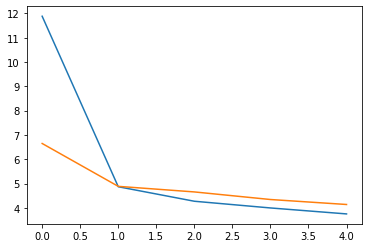

In [160]:
plt.plot(history_df.train_loss, label='train')
plt.plot(history_df.test_loss, label = 'test')

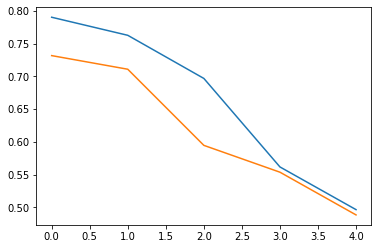

In [158]:
plt.plot(history_df.train_disparity, label='train')
plt.plot(history_df.test_disparity, label = 'test')

In [50]:
latent = model(X_test_taxonomy_tensor, X_test_pathways_tensor)[-1].detach().numpy()
reconstruction = model(X_test_taxonomy_tensor, X_test_pathways_tensor)[0].detach().numpy()

In [53]:
reconstruction_inv = pd.DataFrame(np.apply_along_axis(inv_phylogeny_transform_data, 1, reconstruction, U=U, S=S), columns = X_taxonomy_test.columns, index = X_taxonomy_test.index)
true_inv = pd.DataFrame(np.apply_along_axis(inv_phylogeny_transform_data, 1, X_test_taxonomy_tensor.detach().numpy(), U=U, S=S), columns = X_taxonomy_test.columns, index = X_taxonomy_test.index)
true_inv[true_inv<0]=0
reconstruction_inv[reconstruction_inv<0]=0

Text(0.5, 1.0, '0.07565798496718454')

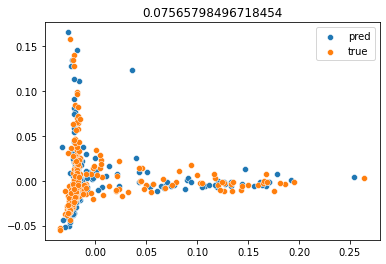

In [54]:
pcoa1 = pcoa(squareform(pdist(true_inv))).samples; # True
pcoa2 = pcoa(squareform(pdist(reconstruction_inv))).samples;  # Reconstruction

Tmtx1, Tmtx2, Tdisp = procrustes(pcoa1.iloc[:, :2], pcoa2.iloc[:, :2])

sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], label = 'pred')
sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], label = 'true')
plt.title(Tdisp)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

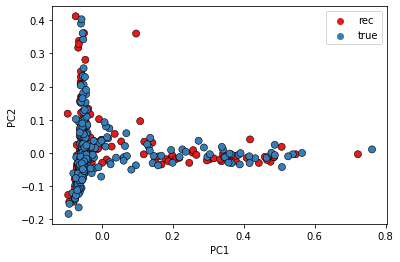

In [55]:
X_test_rec_df = pd.DataFrame(reconstruction_inv)
X_test_rec_df['data'] = 'rec'

X_test_df = pd.DataFrame(true_inv)
X_test_df['data'] = 'true'

taxonomy_df = pd.concat([X_test_rec_df, X_test_df], axis=0)
taxonomy_pcoa = pcoa(squareform(pdist(taxonomy_df.set_index('data'), 'euclidean'))).samples
sns.scatterplot(x = taxonomy_pcoa.PC1, y=taxonomy_pcoa.PC2, palette = 'Set1', s=50, legend=True, edgecolor='k', hue =taxonomy_df['data'].values)

<AxesSubplot:>

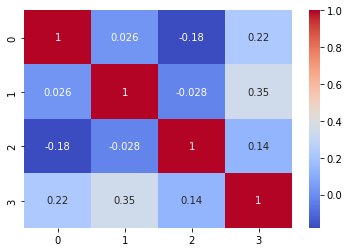

In [56]:
sns.heatmap(pd.DataFrame(latent).corr(), cmap = 'coolwarm', annot=True)